In [23]:
# Core scientific stack
!pip install numpy torch torchvision scikit-learn

# ONNX and runtime (clean install)
!pip install --no-cache-dir onnxruntime onnx

# Model analysis tools
!pip install timm thop onnx_opcounter matplotlib

# Optional tooling (if needed for quantization or extra features)
!pip install onnxruntime-tools

# Skip this cell if not using Google Colab

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [24]:
#@title Import Statements for Quantization (Collapsed)

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingWarmRestarts
from onnxruntime.quantization import quantize_static, CalibrationDataReader, QuantFormat, QuantType
import onnxruntime as ort
import onnx
from torchvision import transforms, datasets
from torchvision.datasets import CIFAR10, ImageFolder
import torchvision.transforms.v2 as v2
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, InterpolationMode
from torchvision.transforms.functional import InterpolationMode
import re
from functools import partial
from typing import List
import torch
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.layers.squeeze_excite import EffectiveSEModule
from timm.models import register_model, build_model_with_cfg, named_apply, generate_default_cfgs
from timm.layers import DropPath
from timm.layers import LayerNorm2d
import timm
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import onnxruntime as ort
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import numpy as np
import time
import os
import csv
import timm
from thop import profile
import torch
from onnx_opcounter import calculate_params, calculate_macs

In [4]:
#@title RDNetTiny Implementation (Collapsed)


class RDNetClassifierHead(nn.Module):
    def __init__(
        self,
        in_features: int,
        num_classes: int,
        drop_rate: float = 0.,
    ):
        super().__init__()
        self.in_features = in_features
        self.num_features = in_features

        self.norm = nn.LayerNorm(in_features)
        self.drop = nn.Dropout(drop_rate)
        self.fc = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

    def reset(self, num_classes):
        self.fc = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

    def forward(self, x, pre_logits: bool = False):
        x = x.mean([-2, -1])
        x = self.norm(x)
        x = self.drop(x)
        if pre_logits:
            return x
        x = self.fc(x)
        return x


class PatchifyStem(nn.Module):
    def __init__(self, num_input_channels, num_init_features, patch_size=4):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(num_input_channels, num_init_features, kernel_size=patch_size, stride=patch_size),
            LayerNorm2d(num_init_features),
        )

    def forward(self, x):
        return self.stem(x)


class Block(nn.Module): #this is Feature MIXER
    """D == Dw conv, N == Norm, F == Feed Forward, A == Activation"""
    def __init__(self, in_chs, inter_chs, out_chs):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_chs, in_chs, groups=in_chs, kernel_size=7, stride=1, padding=3),
            LayerNorm2d(in_chs, eps=1e-6),
            nn.Conv2d(in_chs, inter_chs, kernel_size=1, stride=1, padding=0),
            nn.GELU(),
            nn.Conv2d(inter_chs, out_chs, kernel_size=1, stride=1, padding=0),
        )

    def forward(self, x):
        return self.layers(x)


class BlockESE(nn.Module): # this is Feature MIXER
    """D == Dw conv, N == Norm, F == Feed Forward, A == Activation"""
    def __init__(self, in_chs, inter_chs, out_chs):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_chs, in_chs, groups=in_chs, kernel_size=7, stride=1, padding=3),
            LayerNorm2d(in_chs, eps=1e-6),
            nn.Conv2d(in_chs, inter_chs, kernel_size=1, stride=1, padding=0),
            nn.GELU(),
            nn.Conv2d(inter_chs, out_chs, kernel_size=1, stride=1, padding=0),
            EffectiveSEModule(out_chs),
        )

    def forward(self, x):
        return self.layers(x)


class DenseBlock(nn.Module):
    def __init__(
        self,
        num_input_features,
        growth_rate,
        bottleneck_width_ratio, # I think this is wide part of bottleneck
        drop_path_rate,
        drop_rate=0.0,
        rand_gather_step_prob=0.0,
        block_idx=0,
        block_type="Block",
        ls_init_value=1e-6,
        **kwargs,
    ):
        super().__init__()
        self.drop_rate = drop_rate
        self.drop_path_rate = drop_path_rate
        self.rand_gather_step_prob = rand_gather_step_prob
        self.block_idx = block_idx
        self.growth_rate = growth_rate

        self.gamma = nn.Parameter(ls_init_value * torch.ones(growth_rate)) if ls_init_value > 0 else None
        growth_rate = int(growth_rate)
        inter_chs = int(num_input_features * bottleneck_width_ratio / 8) * 8

        if self.drop_path_rate > 0:
            self.drop_path = DropPath(drop_path_rate)

        self.layers = eval(block_type)(
            in_chs=num_input_features,
            inter_chs=inter_chs,
            out_chs=growth_rate, # the concatentation of features
        )

    def forward(self, x):
        if isinstance(x, List):
            x = torch.cat(x, 1)
        x = self.layers(x)

        if self.gamma is not None:
            x = x.mul(self.gamma.reshape(1, -1, 1, 1))

        if self.drop_path_rate > 0 and self.training:
            x = self.drop_path(x)
        return x


class DenseStage(nn.Sequential):
    def __init__(self, num_block, num_input_features, drop_path_rates, growth_rate, **kwargs):
        super().__init__()
        for i in range(num_block):
            layer = DenseBlock(
                num_input_features=num_input_features,
                growth_rate=growth_rate,
                drop_path_rate=drop_path_rates[i],
                block_idx=i,
                **kwargs,
            )
            num_input_features += growth_rate
            self.add_module(f"dense_block{i}", layer)
        self.num_out_features = num_input_features

    def forward(self, init_feature):
        features = [init_feature]
        for module in self:
            new_feature = module(features)
            features.append(new_feature)
        return torch.cat(features, 1)


class RDNet(nn.Module):
    def __init__(
        self,
        num_init_features=64,
        growth_rates=(64, 104, 128, 128, 128, 128, 224),
        num_blocks_list=(3, 3, 3, 3, 3, 3, 3),
        bottleneck_width_ratio=4,
        zero_head=False,
        in_chans=3,  # timm option [--in-chans]
        num_classes=1000,  # timm option [--num-classes]
        drop_rate=0.0,  # timm option [--drop: dropout ratio]
        drop_path_rate=0.0,  # timm option [--drop-path: drop-path ratio]
        checkpoint_path=None,  # timm option [--initial-checkpoint]
        transition_compression_ratio=0.5,
        ls_init_value=1e-6,
        is_downsample_block=(None, True, True, False, False, False, True),
        block_type="Block",
        head_init_scale: float = 1.,
        **kwargs,
    ):
        super().__init__()
        assert len(growth_rates) == len(num_blocks_list) == len(is_downsample_block)

        self.num_classes = num_classes
        if isinstance(block_type, str):
            block_type = [block_type] * len(growth_rates)

        # stem
        self.stem = PatchifyStem(in_chans, num_init_features, patch_size=4)

        # features
        self.feature_info = []
        self.num_stages = len(growth_rates)
        curr_stride = 4  # stem_stride
        num_features = num_init_features
        dp_rates = [x.tolist() for x in torch.linspace(0, drop_path_rate, sum(num_blocks_list)).split(num_blocks_list)]

        dense_stages = []
        for i in range(self.num_stages):
            dense_stage_layers = []
            if i != 0:
                compressed_num_features = int(num_features * transition_compression_ratio / 8) * 8
                k_size = stride = 1
                if is_downsample_block[i]:
                    curr_stride *= 2
                    k_size = stride = 2
                dense_stage_layers.append(LayerNorm2d(num_features))
                dense_stage_layers.append(
                    nn.Conv2d(num_features, compressed_num_features, kernel_size=k_size, stride=stride, padding=0)
                )
                num_features = compressed_num_features

            stage = DenseStage(
                num_block=num_blocks_list[i],
                num_input_features=num_features,
                growth_rate=growth_rates[i],
                bottleneck_width_ratio=bottleneck_width_ratio,
                drop_rate=drop_rate,
                drop_path_rates=dp_rates[i],
                ls_init_value=ls_init_value,
                block_type=block_type[i],
            )
            dense_stage_layers.append(stage)
            num_features += num_blocks_list[i] * growth_rates[i]

            if i + 1 == self.num_stages or (i + 1 != self.num_stages and is_downsample_block[i + 1]):
                self.feature_info += [
                    dict(
                        num_chs=num_features,
                        reduction=curr_stride,
                        module=f'dense_stages.{i}',
                        growth_rate=growth_rates[i],
                    )
                ]
            dense_stages.append(nn.Sequential(*dense_stage_layers))
        self.dense_stages = nn.Sequential(*dense_stages)

        # classifier
        self.head = RDNetClassifierHead(num_features, num_classes, drop_rate=drop_rate)

        # initialize weights
        named_apply(partial(_init_weights, head_init_scale=head_init_scale), self)

        if zero_head:
            nn.init.zeros_(self.head[-1].weight.data)
            if self.head[-1].bias is not None:
                nn.init.zeros_(self.head[-1].bias.data)

        if checkpoint_path is not None:
            self.load_state_dict(torch.load(checkpoint_path, map_location="cpu"))

    @torch.jit.ignore
    def get_classifier(self):
        return self.head.fc

    def reset_classifier(self, num_classes=0, global_pool=None):
        assert global_pool is None
        self.head.reset(num_classes)

    def forward_head(self, x, pre_logits: bool = False):
        return self.head(x, pre_logits=True) if pre_logits else self.head(x)

    def forward_features(self, x):
        x = self.stem(x)
        x = self.dense_stages(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

    def group_matcher(self, coarse=False):
        assert not coarse
        return dict(
            stem=r'^stem',
            blocks=r'^dense_stages\.(\d+)',
        )


def _init_weights(module, name=None, head_init_scale=1.0):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight)
    elif isinstance(module, nn.BatchNorm2d):
        nn.init.constant_(module.weight, 1)
        nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.Linear):
        nn.init.constant_(module.bias, 0)
        if name and 'head.' in name:
            module.weight.data.mul_(head_init_scale)
            module.bias.data.mul_(head_init_scale)


def rdnet_tiny(pretrained=False, num_classes=1000, checkpoint_path=None, device="cpu", **kwargs):
    n_layer = 7
    model_args = {
        "num_init_features": 64,
        "growth_rates": [64, 104, 128, 128, 128, 128, 224],
        "num_blocks_list": [3] * n_layer,
        "is_downsample_block": (None, True, True, False, False, False, True),
        "transition_compression_ratio": 0.5,
        "block_type": ["Block", "Block", "BlockESE", "BlockESE", "BlockESE", "BlockESE", "BlockESE"],
        "num_classes": num_classes,
    }

    model = RDNet(**{**model_args, **kwargs})

    if pretrained:
        assert checkpoint_path is not None, "Please provide checkpoint_path for pretrained weights"
        state_dict = torch.load(checkpoint_path, map_location=device, weights_only=False)
        model.load_state_dict(state_dict, strict=False)

    return model


# Loading the CIFAR10 Image Dataset


*   Our model was trained for the CIFAR10 image classification task. This dataset includes 60,000 images, with 50,000 for training and 10,000 for testing. There are 10 different classes and each image is 32x32 pixels in size.
*   This code also contains the transform needed to make CIFAR10 images fit into our rdnet implementation. You'll notice we need to size the images to 224x224. This is the original size of ImageNet data, and thus why we make this adjustment
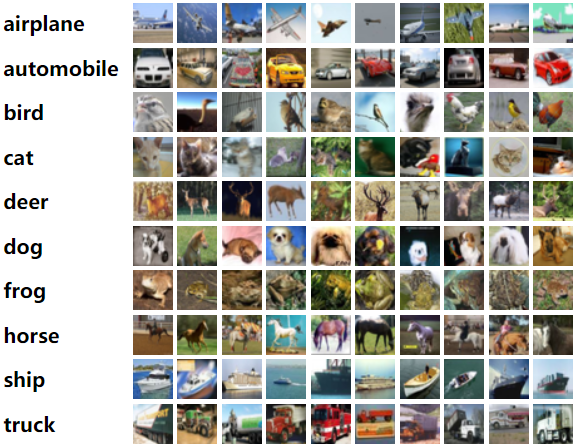


In [5]:
# Define dataset (CIFAR-10)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

CIFAR10_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
CIFAR10_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create a DataLoader for the training and testing data
CIFAR10_train_loader = DataLoader(CIFAR10_train_dataset, batch_size=1, shuffle=True)
CIFAR10_test_loader = DataLoader(CIFAR10_train_dataset, batch_size=1, shuffle=True)

100%|██████████| 170M/170M [00:04<00:00, 42.3MB/s] 


# Setting Device and Paths


*   This is standard practice to defer to a GPU where it is possible, though this quantization ensures that RDNetTiny can be run on CPU efficiently.
*   The paths are set to be used later in the code. Checkpoint is the pretrainined model. Onnx Model is the quantized version of the model.




In [7]:
# Set device and the path names for the checkpoint model and quantized model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
checkpoint_path = "pretrained_models/rdnet_tiny_transfer_learn__valLoss0.1992_valAcc93.86.pth"
onnx_model_path = "pretrained_models/quantized_rdnet_tiny_model.onnx"

# Loading the pre-trained RDNetTiny


*   This section loads the pretrained rdnet_tiny checkpoint from our initial transfer learning. This model was trained on ImageNet-1k and then transfer learned onto CIFAR10, achieving a 93%+ accuracy for CIFAR10 classification.







In [8]:
# Initialize and load the model
model = rdnet_tiny(pretrained=False, num_classes=10) # Set to 10 classes (usually this architecture is suited for the 1k classes of ImageNet-1k)
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"], strict=False)
model.to(device)
model.eval()  # Set the model to evaluation mode

print("Model loaded and set to evaluation mode.")

Model loaded and set to evaluation mode.


# Exporting RDNetTiny to Onnx, then Calibrating


*   Exporting the RDNetTiny model to Onnx is the first necessary step in the quantization effort. Once the model is in Onnx format, we can actually apply quantization to the weights/activations/etc. and reduce the size of the model. Onnxruntime is how we will test inference speeds, and that requires the model in Onnx format.
*   The Calibration Data Reader is used when Onnx is actually applying quantization. Essentially, Onnx needs to see some of the input data so it can analyze the distributions of the latent activations, normally finding mins/maxs.

In [28]:
# Export the model to ONNX format
onnx_path = "pretrained_models/rdnet_tiny_model.onnx"
dummy_input = torch.randn(1, 3, 224, 224).to(device)
torch.onnx.export(model, dummy_input, onnx_path, input_names=['input'], output_names=['output'], verbose=True)

print(f"Model exported to {onnx_path}")

# Define calibration data reader
class MyCalibrationDataReader:
    def __init__(self, data_loader):
        self.data_loader = data_loader
        self.batch_index = 0  # Initialize the batch index

    def get_next(self):
        if self.batch_index < len(self.data_loader):
            batch = next(iter(self.data_loader))  # Get the next batch from the DataLoader
            self.batch_index += 1
            inputs = {'input': batch[0].numpy()}
            return inputs
        else:
            return None


# Pass the CIFAR10 training data through the Calibration Reader, allowing Onnx to index through the training data to better inform quantization.
calibration_data_reader = MyCalibrationDataReader(CIFAR10_train_loader)

Model exported to pretrained_models/rdnet_tiny_model.onnx


# Define the Quantization to be used on RDNetTiny


*   This section defines the static quantization that is going to be applied to RDNetTiny, converting the model from FP32 to INT8.


*   Then call the quantization and apply it to RDNetTiny.





In [10]:
# Quantize Function using ONNX Runtime
def quantize_model(input_model_path, output_model_path):
    # Apply post-training quantization using ONNX Runtime
    quantized_model = quantize_static(
        input_model_path,
        output_model_path,
        calibration_data_reader=calibration_data_reader
    )

    print(f"Quantized model saved to {output_model_path}")

In [11]:
# Quantize and save the quantized model (commenting this out in the demo, given it takes a long time to complete)
# input_model_path = onnx_path
# quantize_model(input_model_path, onnx_model_path)

In [11]:
# Print the structure of the quantized model
def print_quantized_model(onnx_model_path):
  # Load the quantized ONNX model using ONNX Runtime
  model = onnx.load(onnx_model_path)

  # Print all node types
  for idx, node in enumerate(model.graph.node):
    if idx >= 10:
      break
    print(f"Node: {node.name}, OpType: {node.op_type}")

# Quick Function to show how Onnx actually quantized
def detect_quantization_format(model_path):
    model = onnx.load(model_path)
    ops = set(node.op_type for node in model.graph.node)

    if any(op.startswith("QLinear") for op in ops):
        return "QOperator format (INT8 weights and ops)"
    elif "QuantizeLinear" in ops and "DequantizeLinear" in ops:
        return "QDQ format (Quantize-Dequantize around FP32 ops)"
    else:
        return "Not quantized"

In [13]:
# Step 6: Perform inference with the quantized model
print_quantized_model(onnx_model_path)
print("------------------------------------------")
print(str("Quantization Type: " + detect_quantization_format(onnx_model_path)))

Node: /dense_stages/dense_stages.0/dense_stages.0.0/dense_block0/layers/layers/layers.3/Constant, OpType: Constant
Node: /dense_stages/dense_stages.0/dense_stages.0.0/dense_block0/layers/layers/layers.3/Constant_1, OpType: Constant
Node: /dense_stages/dense_stages.0/dense_stages.0.0/dense_block0/layers/layers/layers.3/Constant_2, OpType: Constant
Node: /dense_stages/dense_stages.0/dense_stages.0.0/dense_block1/layers/layers/layers.3/Constant, OpType: Constant
Node: /dense_stages/dense_stages.0/dense_stages.0.0/dense_block1/layers/layers/layers.3/Constant_1, OpType: Constant
Node: /dense_stages/dense_stages.0/dense_stages.0.0/dense_block1/layers/layers/layers.3/Constant_2, OpType: Constant
Node: /dense_stages/dense_stages.0/dense_stages.0.0/dense_block2/layers/layers/layers.3/Constant, OpType: Constant
Node: /dense_stages/dense_stages.0/dense_stages.0.0/dense_block2/layers/layers/layers.3/Constant_1, OpType: Constant
Node: /dense_stages/dense_stages.0/dense_stages.0.0/dense_block2/layer

# Evaluate Quantized and Normal RDNetTiny


*   This cell compares 3 different metrics for the quantized and the unquantized model. Size, Inference Speed (per/total), and classification accuracy.
*   All this testing uses the CIFAR10 testing dataset.



In [12]:
# Function to evaluate model
def evaluate_model(model_func, model_name, dataloader, is_onnx=False):
    correct = 0
    total = 0
    start_time = time.time()

    for idx, (images, labels) in enumerate(dataloader):
        if idx >= 100:
            break

        if is_onnx:
            images_np = images.numpy()
            ort_inputs = {model_func.get_inputs()[0].name: images_np}
            ort_outs = model_func.run(None, ort_inputs)
            outputs = torch.tensor(ort_outs[0])
        else:
            images = images.to('cpu')
            labels = labels.to('cpu')
            outputs = model_func(images)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    accuracy = 100 * correct / total
    inference_time = (end_time - start_time) / total
    total_time = end_time - start_time
    return accuracy, inference_time, total_time


In [13]:
# -----------------------
# Evaluate quantized model
# -----------------------
quantized_model = ort.InferenceSession(onnx_model_path, providers=["CPUExecutionProvider"])
quant_accuracy, quant_inf_time, quant_total_time = evaluate_model(quantized_model, "quantized_rdnet", CIFAR10_test_loader, is_onnx=True)
quant_size = os.path.getsize(onnx_model_path) / (1024 * 1024)

# -----------------------
# Evaluate original model
# -----------------------
# # Load the state_dict
model = rdnet_tiny(pretrained=False, num_classes=10)
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()
torch.save(model.state_dict(), "model_weights.pth")
orig_accuracy, orig_inf_time, orig_total_time = evaluate_model(model, "rdnet_orginal", CIFAR10_test_loader, is_onnx=False)
orig_size = os.path.getsize("model_weights.pth") / (1024 * 1024)

# -----------------------
# Print results
# -----------------------
print("\n--- Model Evaluation Results (on 10 CIFAR-10 test images) ---")
print(f"{'Model':<20} {'Accuracy (%)':<15} {'Inf Time (ms)':<20} {'Total Time (s)':<20} {'Size (MB)':<10}")
print("-" * 85)
print(f"{'Quantized ONNX':<20} {quant_accuracy:<15.2f} {quant_inf_time * 1000:<20.2f} {quant_total_time:<20.2f} {quant_size:<10.2f}")
print(f"{'Original PyTorch':<20} {orig_accuracy:<15.2f} {orig_inf_time * 1000:<20.2f} {orig_total_time:<20.2f} {orig_size:<10.2f}")


--- Model Evaluation Results (on 10 CIFAR-10 test images) ---
Model                Accuracy (%)    Inf Time (ms)        Total Time (s)       Size (MB) 
-------------------------------------------------------------------------------------
Quantized ONNX       96.00           123.01               12.30                24.56     
Original PyTorch     96.00           78.59                7.86                 87.19     


# Demonstration of Quantized Outputs

*   This cell defines a function that can be used to classify you're own personal images. You can save any picture and see what class RDNetTiny-Quantized thinks its class is. This function will also return the time it takes to inference that one image.



In [14]:
# CIFAR-10 class labels
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Load ONNX model once
session = ort.InferenceSession(onnx_model_path, providers=["CPUExecutionProvider"])

def classify_image(pil_image):

    import time

    # Preprocess image
    image = transform(pil_image).unsqueeze(0).numpy()  # (1, C, H, W)

    # Run inference
    start = time.time()
    ort_inputs = {session.get_inputs()[0].name: image}
    ort_outs = session.run(None, ort_inputs)
    end = time.time()

    # Postprocess output
    outputs = torch.tensor(ort_outs[0])
    _, predicted = torch.max(outputs, 1)

    predicted_class = classes[predicted.item()]
    inference_time_ms = (end - start) * 1000

    return predicted_class, inference_time_ms

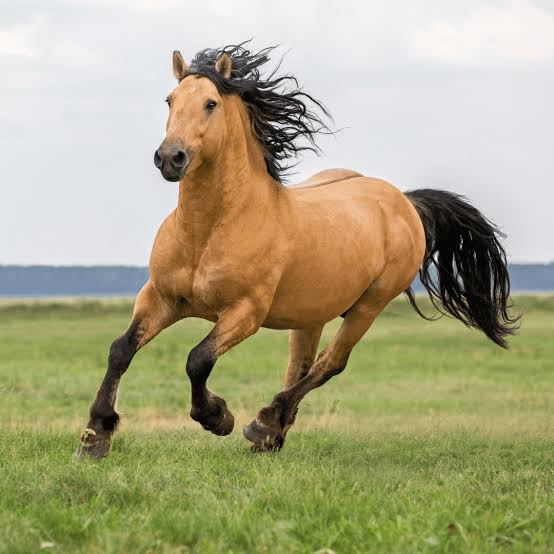

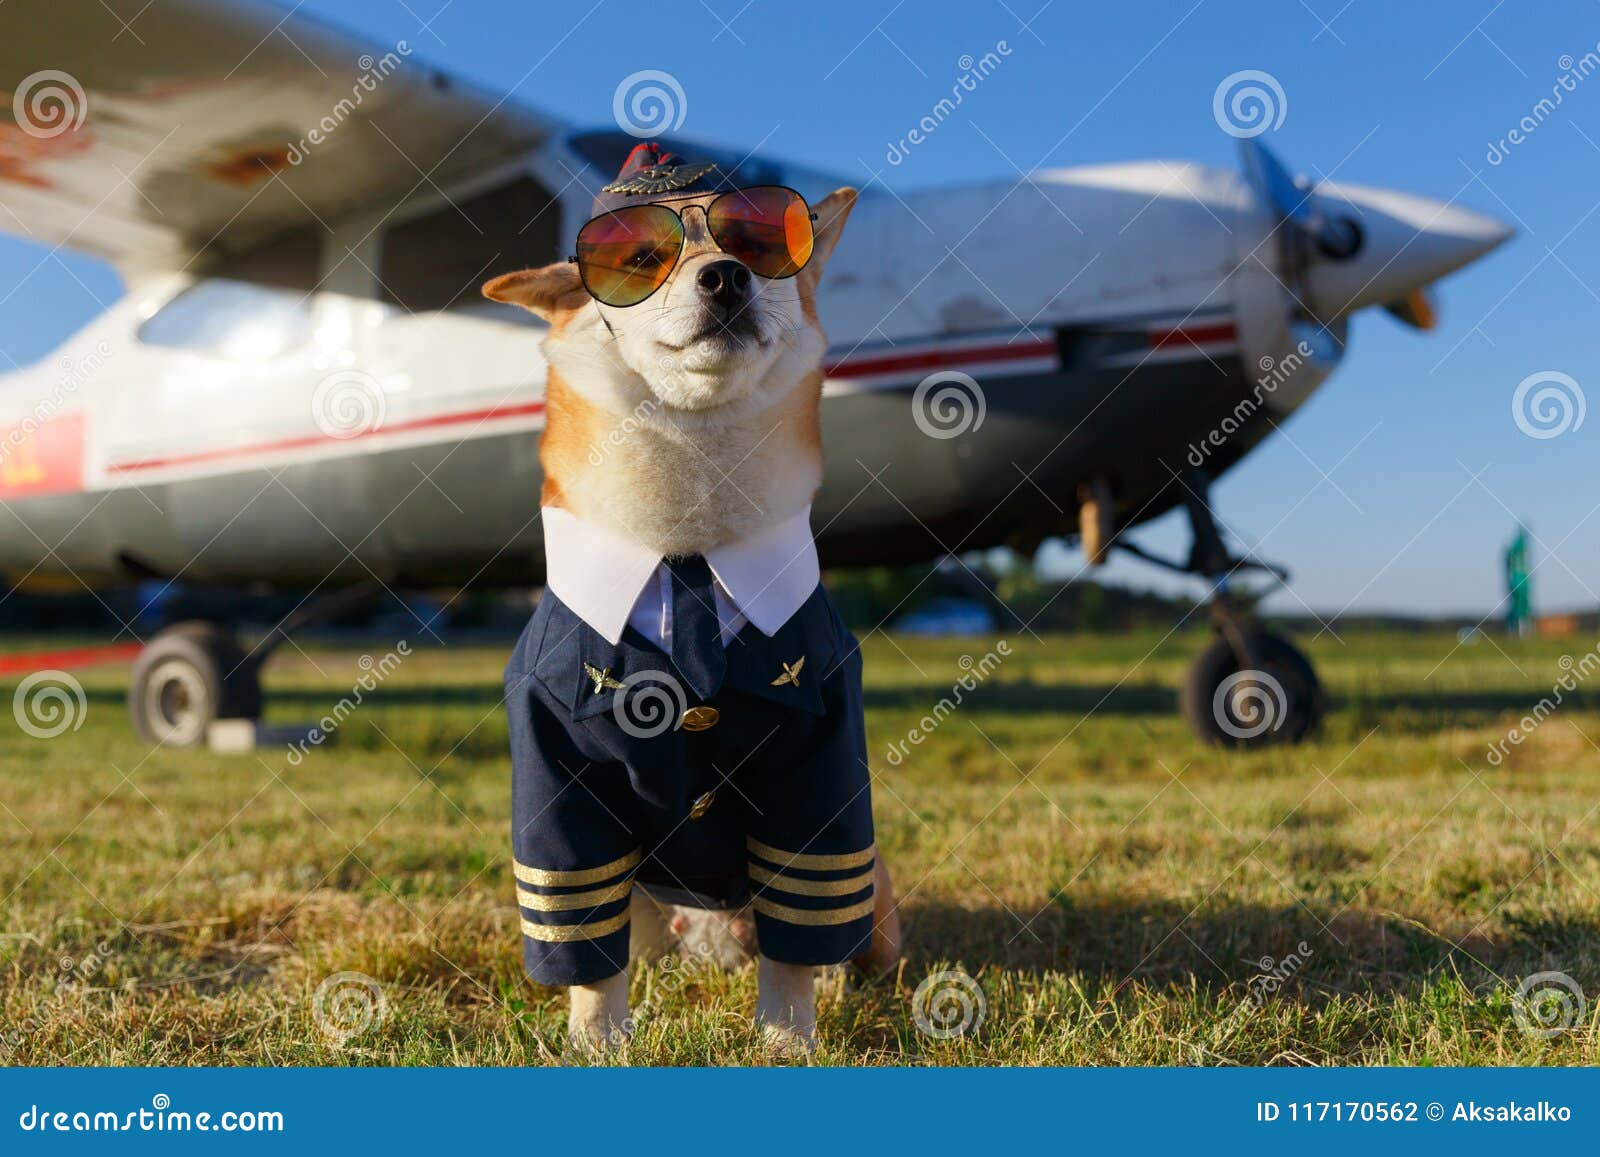

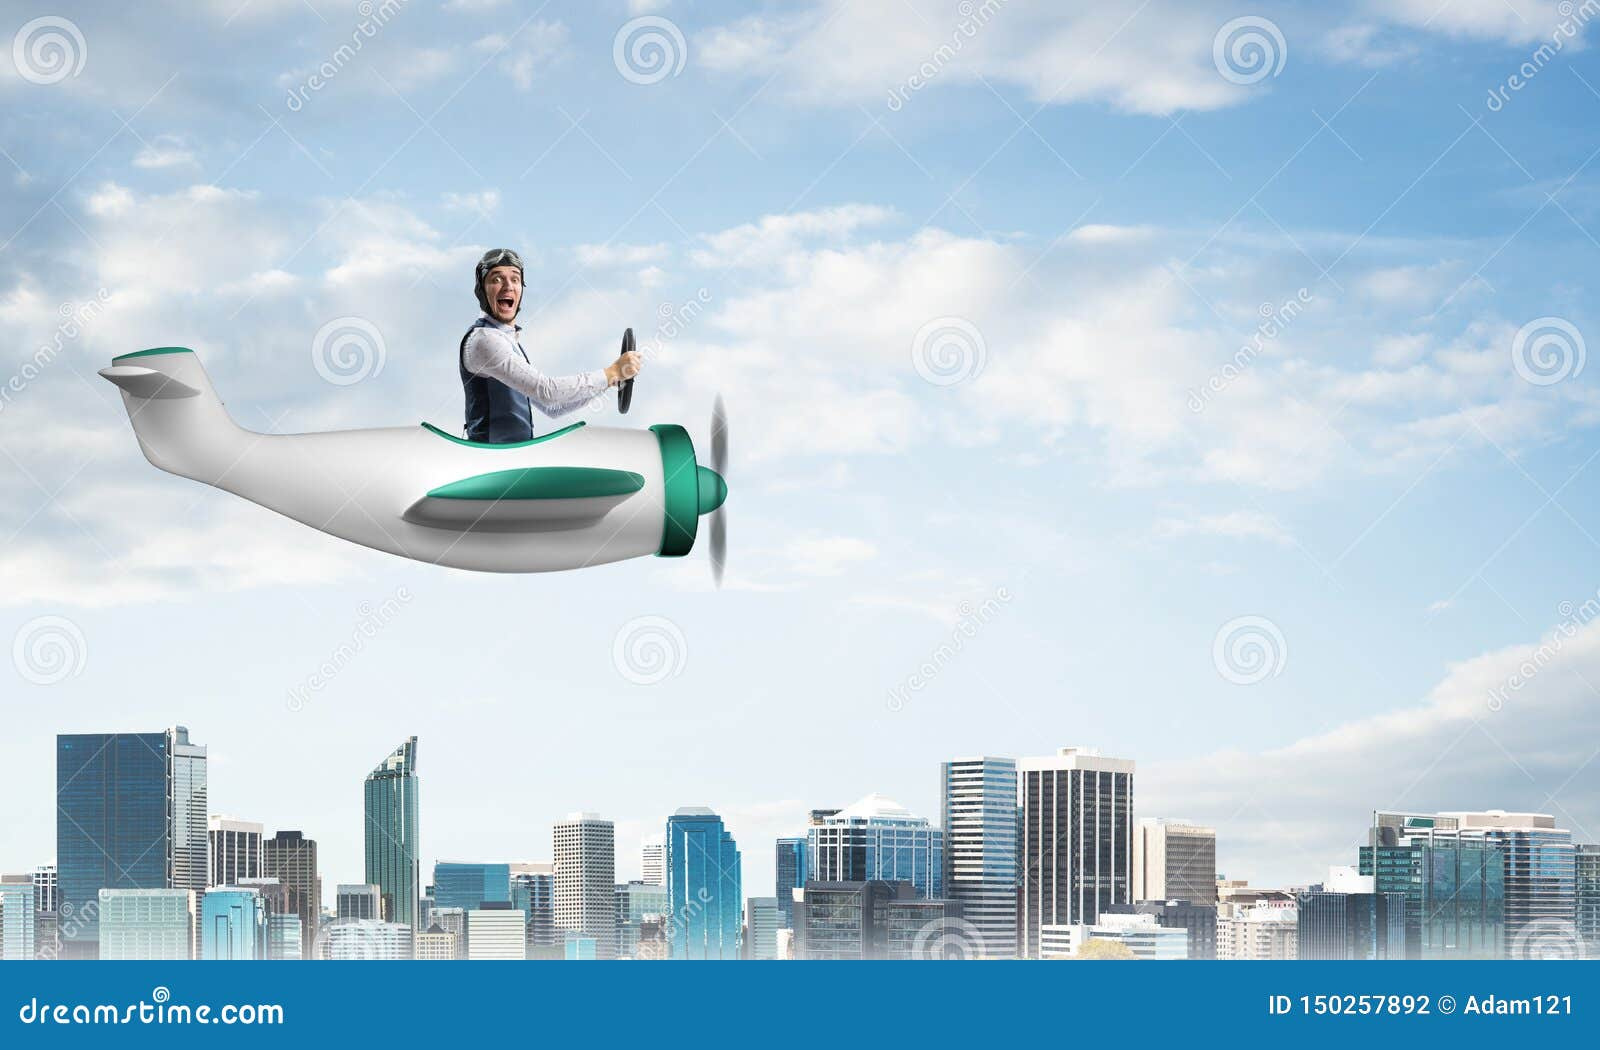

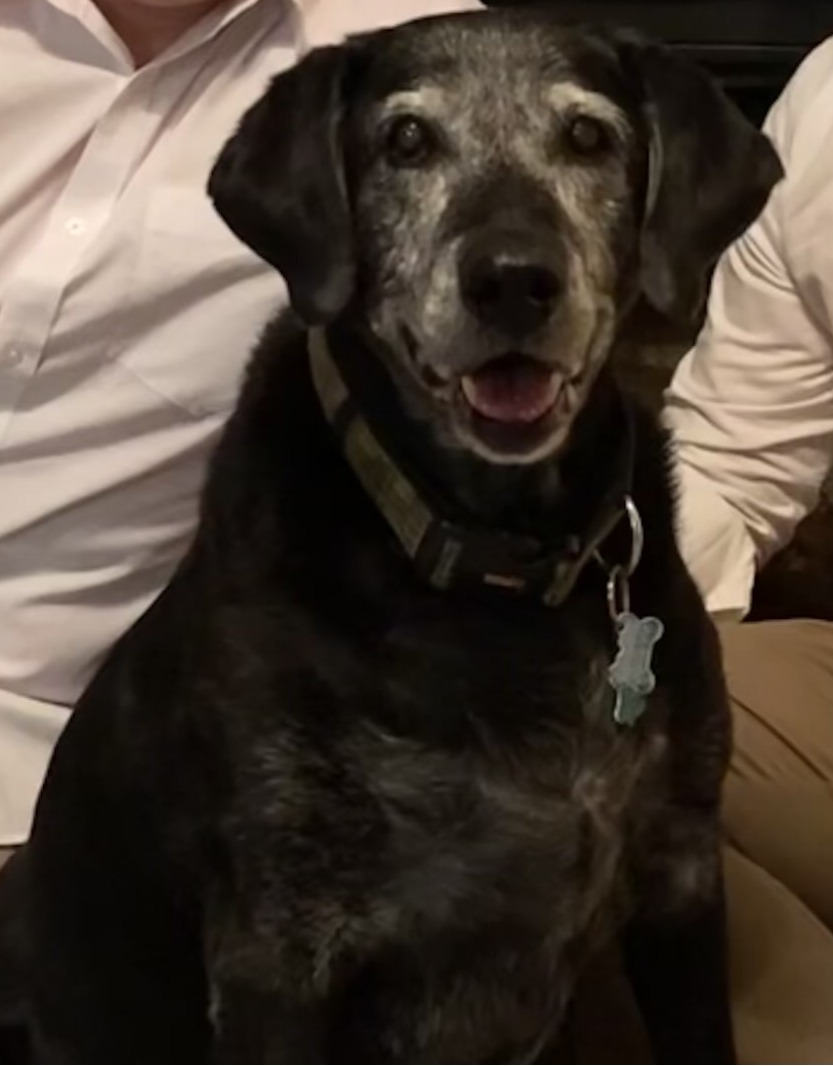

In [16]:
from PIL import Image
from IPython.display import display

# Image path to current picture of horse
horse_path = "img/horse.jpg"
dog_plane_path = "img/dog_plane.jpg"
funny_plane_path = "img/funny_plane.jpg"
pepper_path = "img/pepper.jpg"

# Open and convert to RGB
horse_img = Image.open(horse_path).convert("RGB")
display(horse_img)
horse_img.show()

# Read other images in as well
dog_plane_img = Image.open(dog_plane_path).convert("RGB")
display(dog_plane_img)
dog_plane_img.show()

funny_plane_img = Image.open(funny_plane_path).convert("RGB")
display(funny_plane_img)
funny_plane_img.show()

pepper_img = Image.open(pepper_path).convert("RGB")
display(pepper_img)
pepper_img.show()

In [17]:
classify_image(horse_img)

('horse', 127.99811363220215)

In [18]:
classify_image(dog_plane_img)

('horse', 123.99935722351074)

In [19]:
classify_image(funny_plane_img)

('airplane', 116.00041389465332)

In [20]:
classify_image(pepper_img)

('dog', 124.00197982788086)

# Test against a Random CIFAR10 Image



*   This cell will evaluate a random CIFAR10 image and show you the ground truth and prediction. The prints statement at the bottom is the inference speed as well.



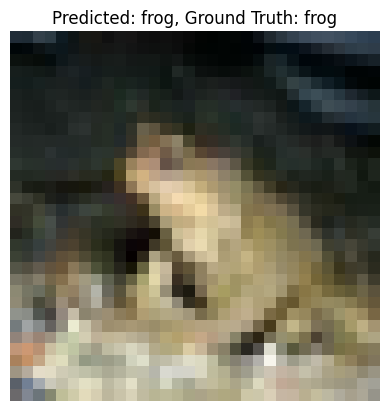

Inference time: 190.00 ms


In [25]:
import matplotlib.pyplot as plt
import random
import time
import os

raw_dataset = datasets.CIFAR10(root='./data', train=False, download=False)

# Select a random image
idx = random.randint(0, len(CIFAR10_test_dataset) - 1)
image, label = CIFAR10_test_dataset[idx]
raw_image, true_label = raw_dataset[idx]

# Prepare image for ONNX
image_np = image.unsqueeze(0).numpy()  # Add batch dimension

# Run inference and time it
start_time = time.time()
ort_inputs = {session.get_inputs()[0].name: image_np}
ort_outs = session.run(None, ort_inputs)
end_time = time.time()

# Postprocess output
outputs = torch.tensor(ort_outs[0])
_, predicted = torch.max(outputs, 1)

# Show image and prediction
plt.imshow(raw_image)
plt.title(f"Predicted: {classes[predicted.item()]}, Ground Truth: {classes[true_label]}")
plt.axis('off')
plt.show()

# Print inference time
inference_time_ms = (end_time - start_time) * 1000
print(f"Inference time: {inference_time_ms:.2f} ms")

# Calculate RDNetTiny MACs and Parameters


*   For the normal RDNetTiny model, we calculate the Parameters and MACs/FLOPS using the THOP package.
*   For onnx operations, we use the onnx_opcounter package to calculate Parameters and MACs/FLOPS.



In [26]:
# Create a dummy input tensor
input = torch.randn(1, 3, 224, 224)

# Calculate MACs and parameters
macs, params = profile(model, inputs=(input,))

# Optionally, format the results for better readability
from thop import clever_format

print("Parameters:", params)
print("MACs:", macs)
print("FLOPS:", macs*2)


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Parameters: 22806666.0
MACs: 5031647984.0
FLOPS: 10063295968.0


In [27]:
# Calculate MACs and parameters
quantized_model_test = onnx.load_model(onnx_model_path)
params = calculate_params(quantized_model_test)
macs = calculate_macs(quantized_model_test)

print('params:', params)
print('MACs:', macs)
print('FLOPS:', macs*2)

Unsupported op: DequantizeLinear
Unsupported op: QuantizeLinear
Unsupported op: LayerNormalization
Unsupported op: Concat
Unsupported op: Div
Unsupported op: Erf
Unsupported op: Mul
Unsupported op: ReduceMean
Unsupported op: HardSigmoid
params: 22833594.0
MACs: 5286307882.0
FLOPS: 10572615764.0
